## Training Conv model

## Training Environment

In [1]:
colab = False

### Import Package

In [3]:
import numpy as np 
import pandas as pd 
import os, sys
import math, random
import datetime, time
import collections
from importlib import reload  

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score,f1_score

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Activation,Dense ,Dropout ,GRU, ConvLSTM2D ,LSTM ,Bidirectional,TimeDistributed,Flatten, Conv1D, MaxPooling1D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth',100)
np.set_printoptions(precision = 2)
np.set_printoptions(threshold=sys.maxsize)

if colab == True:
    from google.colab import files,drive
    drive.mount('/content/drive',force_remount=True) #
    %cd /content
    !cp -r "drive/My Drive/NCCU/Reserach/StockImplement" 'StockImplement'
    %cd /content/StockImplement/
    !pip install mpl_finance 
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
    !dpkg -i libta.deb ta.deb
    !pip install ta-lib
    import talib


# from StockCode.Portfolio import *
import StockCode.StockDataPre
reload(StockCode.StockDataPre)
from StockCode.StockDataPre import *
import StockCode.TechIndex
reload(StockCode.TechIndex)
from StockCode.TechIndex import *
import StockCode.ModelStructure
reload(StockCode.ModelStructure)
from StockCode.ModelStructure import *
import StockCode.PlotUtility
reload(StockCode.PlotUtility)
from StockCode.PlotUtility import *
import StockCode.ModelTrain
reload(StockCode.ModelTrain)
from StockCode.ModelTrain import *
import StockCode.Portfolio
reload(StockCode.Portfolio)
from StockCode.Portfolio import *
from StockCode.st0050 import *

### Load Stock Data (from portfolio)

In [4]:
stocklist = ['0050']
# stocklist = stock0050
lake = call_portfolio(stocklist)
data = portfolio_data(lake, stocklist)

Portfolio add  0050
Load Stock     data from : StockLake/Stock/0050.csv
Load Benchmark data from : StockLake/Benchmark/0050_benchmark.csv
Portfolio add  0050
Start load stock data
                 High        Low       Open      Close     Volume  Adj Close  \
2007-12-31  61.700001  61.049999  61.450001  61.450001  2870000.0  49.378479   

           Stock  
2007-12-31  0050  
Start load benchmark data

-----------------------------------Portfolio Report-----------------------------------
Portfolio [('0050', 1.0)]
Inital Money:  1000000  NTD
Number of Invest Stocks:  1  stocks
Portfolio Start :  2003/01/01 
Portfolio End   :  2020/06/30
Invest Days:  6390  days 
Trading Days:  3075  days
Cumulative Return : -100.0 %
Net Assets: 0  NTD
Risk Free Rate: 0 %
-----------------------------------Portfolio Report-----------------------------------



F:\GoogleDrive\NCCU\Reserach\StockImplement\StockCode\Portfolio.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_benchmark['Daily Return'] = self.df_benchmark["Adj Close"].pct_change(1)


In [5]:
Data = Portfolio(start = '2003/01/01', end = '2020/06/30')
Data.add(stocklist)
Data.load_data(StockLake = lake)

# Data.portfolio()
df__ = lake.df[lake.df == '2000/01/04']


Portfolio add  0050
Start load stock data
                 High        Low       Open      Close     Volume  Adj Close  \
2007-12-31  61.700001  61.049999  61.450001  61.450001  2870000.0  49.378479   

           Stock  
2007-12-31  0050  
Start load benchmark data


F:\GoogleDrive\NCCU\Reserach\StockImplement\StockCode\Portfolio.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_benchmark['Daily Return'] = self.df_benchmark["Adj Close"].pct_change(1)


In [6]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,Stock,ROI,Allocation,Position
2007-12-31,61.700001,61.049999,61.450001,61.450001,2870000.0,49.378479,0050,1.0,1.0,1000000.0
2008-01-02,61.299999,60.000000,60.099998,60.099998,4975000.0,48.293678,0050,NaN,NaN,NaN
2008-01-03,59.349998,58.599998,59.099998,59.099998,7413000.0,47.490124,0050,NaN,NaN,NaN
2008-01-04,59.349998,58.049999,59.099998,59.099998,7686000.0,47.490124,0050,NaN,NaN,NaN
2008-01-07,57.599998,56.299999,56.400002,56.400002,20041000.0,45.320530,0050,NaN,NaN,NaN


## Data Preprocess

### Data Preprocess Parameter

In [7]:
ratio_gap = 3 # +- ratio
split_date = ['2007-12-31', '2017-01-01', '2019-01-01']
window = 30
y = 'Label'

### Calculate Technical Index Data

In [8]:
full_techindi = pd.DataFrame()
for i in stocklist:
    tmp_df = talib_index(data[data['Stock']==i])
    full_techindi = full_techindi.append(tmp_df)   

### Generate Label

In [9]:
# add label
df = add_label(full_techindi, ratio_gap, stocklist, types = 'test_2class')
# drop basic indicator
df.drop(['High','Low','Open','Volume','Adj Close','Stock','ROI','Allocation','Position','Close'],axis=1,inplace=True) #
df.drop(['TANH'],axis=1,inplace=True)

# drop cdl (pattern) indicator
drop_cdl = []
for col in df.columns:
    if 'CDL' in col:
        drop_cdl.append(col)
df.drop(drop_cdl,axis=1,inplace=True)

print(collections.Counter(df['Label']))


test 2 class for (0,1) which 1 is rise 3 % 0 is else
Counter({0: 3019, 1: 56})


### Data Preprocess

In [10]:
## data preprocess procedure
df_stand = standar(df, y = y)
df_ratio = standar(to_ratio(df, y = y), y = y)
df_sma = standar(sma(df, n=5, y = y), y = y)
df_ema = standar(ema(df, n=5, y = y), y = y)
df_ema_10 = standar(ema(df, n=10, y = y), y = y)

df_ema_10, df_stand = align_shape(df_ema_10, df_stand)
df_ema_10, df_ratio = align_shape(df_ema_10, df_ratio)
df_ema_10, df_ema = align_shape(df_ema_10, df_ema)
df_ema_10, df_sma = align_shape(df_ema_10, df_sma)

# df_sma, df_stand = align_shape(df_sma, df_stand)
# df_sma, df_ratio = align_shape(df_sma, df_ratio)
# df_sma, df_ema = align_shape(df_sma, df_ema)
# df_sma, df_ema_10 = align_shape(df_sma, df_ema_10)

df_stand.fillna(0, inplace = True)
df_ratio.fillna(0, inplace = True)
df_sma.fillna(0, inplace = True)
df_ema.fillna(0, inplace = True)
df_ema_10.fillna(0, inplace = True)


### Plot Each Indicator Distplot

In [11]:
# chose plot dataframe
# plot_col(df,3)

### Create Training Window

In [12]:
# Yahoo API 抓取0050資料從2007/12/31開始
print(df.index[:3])
print(df.index[-3:])

# Build training input by standar
df_train_stand, df_valid_stand, df_test_stand = split_data(df_stand, split_date)
# Build training, valid, test dataset
X_train_stand, y_train_stand, X_valid_stand, y_valid_stand, X_test_stand, y_test_stand = input_output(df_train_stand, df_valid_stand, df_test_stand, y = y, window = window)

# Build training input by ratio -> standar
df_train_ratio, df_valid_ratio, df_test_ratio = split_data(df_ratio, split_date)
X_train_ratio, y_train_ratio, X_valid_ratio, y_valid_ratio, X_test_ratio, y_test_ratio = input_output(df_train_ratio, df_valid_ratio, df_test_ratio, y = y, window = window)

# Build training input by sma -> standar
df_train_sma, df_valid_sma, df_test_sma = split_data(df_sma, split_date)
X_train_sma, y_train_sma, X_valid_sma, y_valid_sma, X_test_sma, y_test_sma = input_output(df_train_sma, df_valid_sma, df_test_sma, y = y, window = window)

# Build training input by ema -> standar
df_train_ema, df_valid_ema, df_test_ema = split_data(df_ema, split_date)
X_train_ema, y_train_ema, X_valid_ema, y_valid_ema, X_test_ema, y_test_ema = input_output(df_train_ema, df_valid_ema, df_test_ema, y = y, window = window)

# Build training input by ema_10 -> standar
df_train_ema_10, df_valid_ema_10, df_test_ema_10 = split_data(df_ema_10, split_date)
X_train_ema_10, y_train_ema_10, X_valid_ema_10, y_valid_ema_10, X_test_ema_10, y_test_ema_10 = input_output(df_train_ema_10, df_valid_ema_10, df_test_ema_10, y = y, window = window)

# Original for Compare Image
df_train_ori, df_valid_ori, df_test_ori = split_data(df, split_date)
X_train_ori, y_train_ori, X_valid_ori, y_valid_ori, _, _ = input_output(df_train_ori, df_valid_ori, df_test_ori, y = y, window = window)


Index(['2007-12-31', '2008-01-02', '2008-01-03'], dtype='object')
Index(['2020-06-24', '2020-06-29', '2020-06-30'], dtype='object')


### Data Imbalance Process

In [13]:
## Data Inflation
n=2
# 
X_train_stand, y_train_stand = increase_data(X_train_stand, y_train_stand, 1, n=n)
X_train_stand, y_train_stand = increase_data(X_train_stand, y_train_stand, 2, n=n)

X_train_ratio, y_train_ratio = increase_data(X_train_ratio, y_train_ratio, 1, n=n)
X_train_ratio, y_train_ratio = increase_data(X_train_ratio, y_train_ratio, 2, n=n)

X_train_sma, y_train_sma = increase_data(X_train_sma, y_train_sma, 1, n=n)
X_train_sma, y_train_sma = increase_data(X_train_sma, y_train_sma, 2, n=n)

X_train_ema, y_train_ema = increase_data(X_train_ema, y_train_ema, 1, n=n)
X_train_ema, y_train_ema = increase_data(X_train_ema, y_train_ema, 2, n=n)

X_train_ema_10, y_train_ema_10 = increase_data(X_train_ema_10, y_train_ema_10, 1, n=n)
X_train_ema_10, y_train_ema_10 = increase_data(X_train_ema_10, y_train_ema_10, 2, n=n)


Label 1 Data increase 98 from 2189 to 2287
Label 2 Data increase 0 from 2287 to 2287
Label 1 Data increase 98 from 2189 to 2287
Label 2 Data increase 0 from 2287 to 2287
Label 1 Data increase 98 from 2189 to 2287
Label 2 Data increase 0 from 2287 to 2287
Label 1 Data increase 98 from 2189 to 2287
Label 2 Data increase 0 from 2287 to 2287
Label 1 Data increase 98 from 2189 to 2287
Label 2 Data increase 0 from 2287 to 2287


### Label Describe

#### Original Label Distribution

train Counter({0: 2169, 1: 51})
valid Counter({0: 488, 1: 1})
test Counter({0: 353, 1: 4})


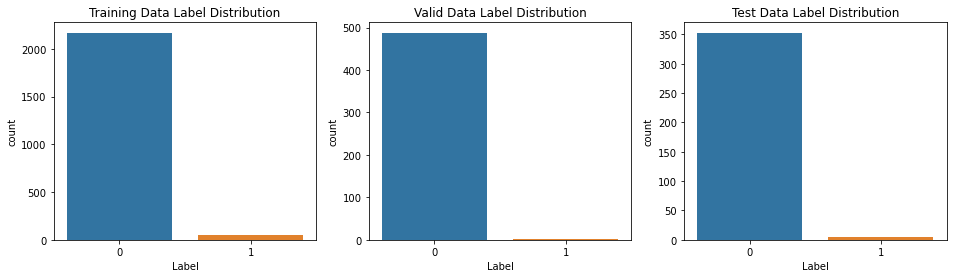

In [14]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.countplot(x = df_train_stand['Label'] , data = df_train_stand,ax = ax[0])
ax[0].set_title('Training Data Label Distribution')
sns.countplot(x = df_valid_stand['Label'] , data = df_valid_stand,ax = ax[1])
ax[1].set_title('Valid Data Label Distribution')
sns.countplot(x = df_test_stand['Label'] , data = df_test_stand,ax = ax[2])
ax[2].set_title('Test Data Label Distribution')
print('train',collections.Counter(df_train_stand['Label']))
print('valid',collections.Counter(df_valid_stand['Label']))
print('test',collections.Counter(df_test_stand['Label']))

#### After Data Imbalance Process Train Data Distribution

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


train Counter({0: 2140, 1: 147})
valid Counter({0: 457, 1: 1})
test Counter({0: 322, 1: 4})


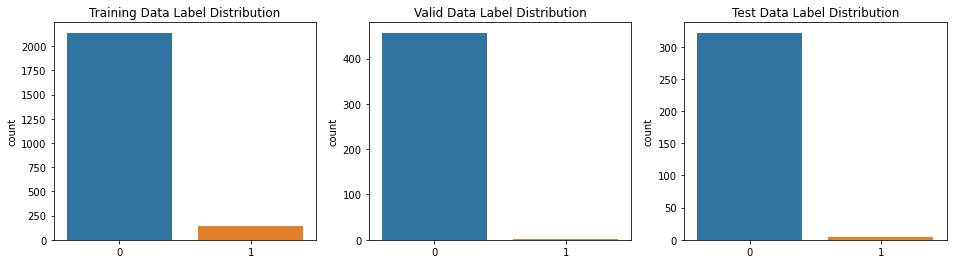

In [15]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.countplot(np_count(y_train_stand),ax = ax[0])
ax[0].set_title('Training Data Label Distribution')
sns.countplot(np_count(y_valid_stand),ax = ax[1])
ax[1].set_title('Valid Data Label Distribution')
sns.countplot(np_count(y_test_stand),ax = ax[2])
ax[2].set_title('Test Data Label Distribution')

print('train',collections.Counter(np_count(y_train_stand)))
print('valid',collections.Counter(np_count(y_valid_stand)))
print('test',collections.Counter(np_count(y_test_stand)))

108


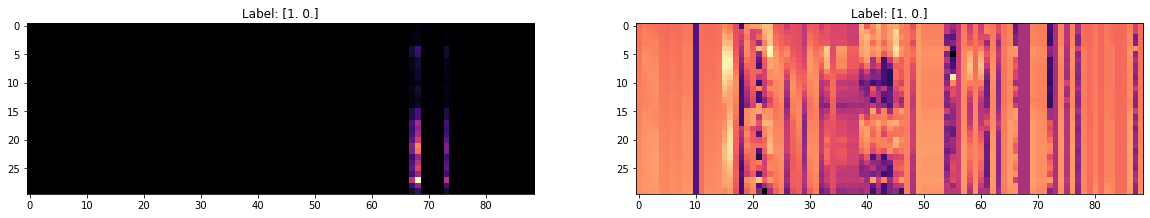

In [16]:
num = random.randint(0,256)
print(num)
a = X_valid_stand[:, :, :,np.newaxis]
b = X_valid_ori[:, :, :,np.newaxis]
fig,ax = plt.subplots(1,2,figsize=(20,16))
# fig.colorbar()
im = ax[0].imshow(b[num][:,:,0],cmap='magma')
im = ax[0].set_title("Label: {}".format(y_valid_ori[num]))
im = ax[1].imshow(a[num][:,:,0],cmap='magma')
im = ax[1].set_title("Label: {}".format(y_valid_stand[num]))
# fig.colorbar(im, ax=ax[0], shrink=0.5)
# plt.colorbar(im ,ax=ax.ravel().tolist())

## Model Training

### Training Parameter

In [ ]:
import StockCode.ModelStructure
reload(StockCode.ModelStructure)
from StockCode.ModelStructure import *

# parameter 
epochs = 20
shuffle = False
batch_size = 64

model_folder = 'model'
training_folder = 'training_history'
model_suffix = '_best_model'

# class weight
class_weight = True
if class_weight:
    weight = {0: 0.1, 1: 0.45, 2: 0.45 }
    
# training model
training_dict = {
#     SimpleRestNet(): 'SimpleRestNet',
#     MultiInput(): 'MultiInput',
#     resnet_18(): 'resnet_18',
    MultiInputII(): 'MultiInputII'
}

def break_line():
    print('-'*100)
    print('\n'*2)
    print('-'*100)
    return

### Model Structure

In [ ]:
def model_structure(model, summary = True, plot = False, name = 'model.png'):
    if summary:
        model.summary()
    if plot:
        keras.utils.plot_model(model, os.path.join(model_folder, name), show_shapes = True)

counter = 0
for key,value in training_dict.items():
    print(counter,value)
    counter += 1
    model_structure(key, name = value + '_model.png',summary=False ,plot=True)        

In [ ]:
# MultiInputII().summary()

### Training Setting

### Training Loop

In [ ]:
%%time

training_time = []
training_time.append(datetime.datetime.now())
print(datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

Input = {
    "input_standar": X_train_stand[:,:,:,np.newaxis] , 
    "input_ratio": X_train_ratio[:,:,:,np.newaxis], 
    "input_sma": X_train_sma[:,:,:,np.newaxis],
    "input_ema": X_train_ema[:,:,:,np.newaxis],
    "input_ema_10": X_train_ema_10[:,:,:,np.newaxis]
} 
Predict = {
    "input_standar": X_test_stand[:,:,:,np.newaxis] , 
    "input_ratio": X_test_ratio[:,:,:,np.newaxis], 
    "input_sma": X_test_sma[:,:,:,np.newaxis],
    "input_ema": X_test_ema[:,:,:,np.newaxis],
    "input_ema_10": X_test_ema_10[:,:,:,np.newaxis]
} 

Output = y_train_stand

for keys, values in training_dict.items():
    print(values,'\n')
    model_train(
        Input, Output, 
        model = keys, epochs = epochs, shuffle = False ,
        prefix = values, metric = metric, class_weight = weight
    )
    break_line()
    training_time.append(datetime.datetime.now())

training_time = [t1-t2 for t1,t2 in zip(training_time[1:],training_time[:-1])]

print('total training {} minutes'.format(round(((training_time[-1] - training_time[0])/60).seconds,2)))



### Summary Training History

In [ ]:
def metric(y_truth, y_pred):
    acc = accuracy_score(y_truth, y_pred)*100
    recall = recall_score(y_truth, y_pred, average='micro')*100
    f1 = f1_score(y_truth, y_pred, average='micro')*100
    return [acc,recall,f1]

# if colab ==True:
#     model_folder = os.path.join("/content/drive/My Drive/NCCU/Reserach/StockImplement",model_folder)

training_record='training_record.csv'
record_path = os.path.join(model_folder, training_record)

test_list = []
model_list = []
history_list = []
for key,value in training_dict.items():
    test_list.append(value)
    model_list.append(value + model_suffix + '.h5')
    history_list.append(value + model_suffix + '.csv')
    
column_list = ['ModelStructure','TrainMinutes','epochs','batch_size','window','ratio_gap','inflate','class_weight','acc','recall','f1']
train_parameter = [epochs, batch_size, window, ratio_gap, n, weight]

counter = 0
record = []
for j in range(len(test_list)):
    tmp_list = []
    tmp_list.append(test_list[counter]) # model structure
    tmp_list.append(round(training_time[counter].seconds/60,1)) # training time minutes
    tmp_list.extend(train_parameter) # training parameter
    model_path = os.path.join(model_folder, model_list[counter])
    model = tf.keras.models.load_model(model_path)
    y_pred = np.argmax(model.predict(Predict) , axis=1)
    y_truth = np.argmax(y_test_stand, axis=1)
    metric_index = metric(y_truth,y_pred)
    tmp_list.extend(metric_index)
    record.append(tmp_list)        
    counter += 1

this_training = pd.DataFrame(record,columns = column_list)    
if os.path.isfile(record_path):
    df_threshold = pd.read_csv(record_path)
    df_threshold = pd.concat([df_threshold,this_training])
else:
    df_threshold = this_training
df_threshold.to_csv(record_path,index=False)
df_threshold

In [ ]:
index=0

model_plot(model_list[index], history_list[index], Predict, y_test_stand)    


### Naive Test

In [ ]:
y_truth = np.argmax(y_test_stand, axis=1)
y_pred = [0]*len(y_truth)
acc = accuracy_score(y_truth, y_pred)*100
print('setting every input predict 0 have accuracy {} %'.format(acc))

In [ ]:
# print(' {} classified accuracy : {} %'.format(model_name,accuracy_score(y_truth, y_pred)*100),'\n')
# print(classification_report(y_truth, y_pred, zero_division=0))
# print('Prediction','\n  ',collections.Counter(y_pred))
# print('Truth','\n  ',collections.Counter(y_truth))